# LeNet-5

Import statements

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, losses
from tqdm import tqdm
import shutil
import ast

Annotations Only Dataframe creation

In [3]:
#Read both csv files into pandas dataframes
regularDataframe = pd.read_csv(r"C:\Users\ethan\Documents\University\2nd Year\ADS2002\CatheterDataset\train.csv")
annotatedDataframe = pd.read_csv(r"C:\Users\ethan\Documents\University\2nd Year\ADS2002\CatheterDataset\train_annotations.csv")

#Add PatientID column from the regular dataframe to the annotated dataframe
df = annotatedDataframe.merge(regularDataframe[['StudyInstanceUID', 'PatientID']], on='StudyInstanceUID', how='left')

#Convert string to list of lists in the column that represents the coordinates of the catheter outline
df['data'] = df['data'].apply(lambda x: ast.literal_eval(x))

#Drop all rows which are incompletely imaged NGTs or Swan Ganz catheters
df = df[~df['label'].isin(['NGT - Incompletely Imaged', 'Swan Ganz Catheter Present'])]

df

,StudyInstanceUID,label,data,PatientID
0,1.2.826.0.1.3680043.8.498.12616281126973421762...,CVC - Normal,"[[1487, 1279], [1477, 1168], [1472, 1052], [14...",ac2e8d106
1,1.2.826.0.1.3680043.8.498.12616281126973421762...,CVC - Normal,"[[1328, 7], [1347, 101], [1383, 193], [1400, 2...",ac2e8d106
2,1.2.826.0.1.3680043.8.498.72921907356394389969...,CVC - Borderline,"[[801, 1207], [812, 1112], [823, 1023], [842, ...",35ac6438a
3,1.2.826.0.1.3680043.8.498.11697104485452001927...,CVC - Normal,"[[1366, 961], [1411, 861], [1453, 751], [1508,...",156d90dd4
4,1.2.826.0.1.3680043.8.498.87704688663091069148...,NGT - Normal,"[[1862, 14], [1845, 293], [1801, 869], [1716, ...",26da0d5ad
...,...,...,...,...
17994,1.2.826.0.1.3680043.8.498.18590666552942008211...,ETT - Normal,"[[1489, 631], [1515, 571], [1563, 535], [1596,...",9754e5843
17995,1.2.826.0.1.3680043.8.498.18590666552942008211...,CVC - Normal,"[[1250, 1105], [1247, 1031], [1248, 970], [126...",9754e5843
17996,1.2.826.0.1.3680043.8.498.66774579023475418162...,CVC - Normal,"[[1379, 1402], [1389, 1233], [1386, 1137], [13...",89018570d
17997,1.2.826.0.1.3680043.8.498.18560506324214035535...,CVC - Normal,"[[1302, 1543], [1308, 1488], [1317, 1355], [13...",7c1d30a26


All Images Dataframe Creation

In [4]:
#Read both csv files into pandas dataframes
regularDataframe = pd.read_csv(r"C:\Users\ethan\Documents\University\2nd Year\ADS2002\CatheterDataset\train.csv")
annotatedDataframe = pd.read_csv(r"C:\Users\ethan\Documents\University\2nd Year\ADS2002\CatheterDataset\train_annotations.csv")

df = regularDataframe.melt(
    id_vars=["StudyInstanceUID", "PatientID"],
    var_name="label",
    value_name="value"
)

# Keep only the rows where the label is present (value == 1)
df = df[df["value"] == 1].drop(columns="value").reset_index(drop=True)

#Drop all rows which are incompletely imaged NGTs or Swan Ganz catheters
df = df[~df['label'].isin(['NGT - Incompletely Imaged', 'Swan Ganz Catheter Present'])]

df

,StudyInstanceUID,PatientID,label
0,1.2.826.0.1.3680043.8.498.64512214019606325590...,7e5a85f8a,ETT - Abnormal
1,1.2.826.0.1.3680043.8.498.91744690322677781447...,c4d33e912,ETT - Abnormal
2,1.2.826.0.1.3680043.8.498.13141026863513235286...,6efc4b0b9,ETT - Abnormal
3,1.2.826.0.1.3680043.8.498.97840557219108486344...,871190b8e,ETT - Abnormal
4,1.2.826.0.1.3680043.8.498.13355346266941406291...,804f6d606,ETT - Abnormal
...,...,...,...
49784,1.2.826.0.1.3680043.8.498.10069840546274743368...,5d0fe98cc,CVC - Normal
49785,1.2.826.0.1.3680043.8.498.74257566841157531124...,5b5b9ac30,CVC - Normal
49786,1.2.826.0.1.3680043.8.498.46510939987173529969...,7192404d8,CVC - Normal
49787,1.2.826.0.1.3680043.8.498.43173270582850645437...,d4d1b066d,CVC - Normal


Keep only the images that have one catheter 

In [6]:
# Keep only StudyInstanceUIDs that occur exactly once
unique_images = df.groupby("StudyInstanceUID").filter(lambda x: len(x) == 1)
unique_images

,StudyInstanceUID,PatientID,label
9,1.2.826.0.1.3680043.8.498.93345761486297843389...,ebdcd4038,ETT - Abnormal
29,1.2.826.0.1.3680043.8.498.11200290070011573124...,c4dff524f,ETT - Abnormal
64,1.2.826.0.1.3680043.8.498.69590675603773156221...,6f110a060,ETT - Abnormal
103,1.2.826.0.1.3680043.8.498.11637594688773276129...,6f110a060,ETT - Borderline
124,1.2.826.0.1.3680043.8.498.10333305168854328602...,4fae27b09,ETT - Borderline
...,...,...,...
49780,1.2.826.0.1.3680043.8.498.85543708701293903513...,1119919df,CVC - Normal
49782,1.2.826.0.1.3680043.8.498.10908982342413107306...,dce9cc938,CVC - Normal
49783,1.2.826.0.1.3680043.8.498.53525361705976355115...,d81b38be3,CVC - Normal
49784,1.2.826.0.1.3680043.8.498.10069840546274743368...,5d0fe98cc,CVC - Normal


Train/test split on dataframe

In [9]:
train_df, test_df = train_test_split(unique_images, test_size=0.2, random_state=3)

Split image folder into train and test folders using exact same split as for the dataframe

In [12]:
#Paths to all images, and the train and test folders
all_images_dir = r"C:\Users\ethan\Documents\University\2nd Year\ADS2002\all_images"
train_dir = r"C:\Users\ethan\Documents\University\2nd Year\ADS2002\CatheterDataset\train"
test_dir  = r"C:\Users\ethan\Documents\University\2nd Year\ADS2002\CatheterDataset\test"

#Make sure that the train/test folders exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

#Function to move images from all_images to dest_dir, guided by the split that has been applied to df
def move_images(df, dest_dir):
    k=0
    for fname in tqdm(df["StudyInstanceUID"], desc=f"Moving to {os.path.basename(dest_dir)}"):
        src = os.path.join(all_images_dir, fname + ".jpg")
        dst = os.path.join(dest_dir, fname + ".jpg")
        if os.path.exists(src):
            shutil.copy(src, dst)
        else:
            k+=1
    return k

#Apply the function to both the train and test images
print(f"Skipped {move_images(train_df, train_dir)} image IDs in train_df")
print(f"Skipped {move_images(test_df, test_dir)} image IDs in test_df")

Moving to train: 100%|██████████| 15344/15344 [01:53<00:00, 135.67it/s]


Skipped 0 image IDs in train_df


Moving to test: 100%|██████████| 3836/3836 [00:27<00:00, 137.80it/s]

Skipped 0 image IDs in test_df


Format x data by resizing images and putting into an array of length 15008 (train) and 3752 (test). Then, we normalise the pixel values and fix dimensions

In [14]:
x_train = []
bad_files = []

for fname in tqdm(os.listdir(r"C:\Users\ethan\Documents\University\2nd Year\ADS2002\CatheterDataset\train")):
    try:
        #Retrieve the image based on its ID
        img = Image.open(os.path.join(r"C:\Users\ethan\Documents\University\2nd Year\ADS2002\CatheterDataset\train", fname))
        #Resize the image
        img = img.resize((32, 32), Image.Resampling.LANCZOS)
        #Add the image to our list
        x_train.append(img)
    except Exception as e:
        bad_files.append(fname)



100%|██████████| 15344/15344 [05:03<00:00, 50.50it/s]


In [15]:
x_test = []

for fname in tqdm(os.listdir(r"C:\Users\ethan\Documents\University\2nd Year\ADS2002\CatheterDataset\test")):
    try:
        #Retrieve the image based on its ID
        img = Image.open(os.path.join(r"C:\Users\ethan\Documents\University\2nd Year\ADS2002\CatheterDataset\test", fname))
        #Resize the image
        img = img.resize((32, 32), Image.Resampling.LANCZOS)
        #Add the image to our list
        x_test.append(img)
    except Exception as e:
        bad_files.append(fname)

100%|██████████| 3836/3836 [00:53<00:00, 71.63it/s]


In [16]:
#Create temperary storages for the clean x_train and x_test so we don't have to create x_train and x_test from scratch again
x_train_temp = x_train
x_test_temp = x_test

In [17]:
#Convert PIL images to numpy arrays and normalize the pixel values
x_train = np.array([np.array(img, dtype=np.float32)/255.0 for img in x_train_temp])
x_test  = np.array([np.array(img, dtype=np.float32)/255.0 for img in x_test_temp])

#Add channel dimension so the conv2D layer in the model can work
x_train = np.expand_dims(x_train, axis=-1)  #shape is (7254, 32, 32, 1)
x_test = np.expand_dims(x_test, axis=-1)   #shape is (1814, 32, 32, 1)

Format y data by making an array of CVC, NGT or ETT labels that line up with the images in the x data exactly. Then, we convert y data from 'CVC', 'ETT', 'NGT' to 0,1,2, respectively.

In [28]:
y_train = []

#Loop over all image IDs in train folder
for fname in tqdm(os.listdir(r"C:\Users\ethan\Documents\University\2nd Year\ADS2002\CatheterDataset\train")):
  if fname not in bad_files:
    #Retrieve the catheter type that corresponds to the image ID
    label = train_df[train_df["StudyInstanceUID"] == fname[:-4]].iloc[0,2][0:3]
    #Add the label to our list
    y_train.append(label)



100%|██████████| 15344/15344 [00:11<00:00, 1299.50it/s]


In [29]:
y_test = []

#Loop over all images in test folder
for fname in tqdm(os.listdir(r"C:\Users\ethan\Documents\University\2nd Year\ADS2002\CatheterDataset\test")):
  if fname not in bad_files:
    #Retrieve the catheter type that corresponds to the image ID
    label = test_df[test_df["StudyInstanceUID"] == fname[:-4]].iloc[0,2][0:3]
    #Add the label to our list
    y_test.append(label)

100%|██████████| 3836/3836 [00:01<00:00, 3466.10it/s]


In [30]:
#Instantiate the label encoder
le = LabelEncoder()

#Transform the strings to integers
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

A few checks to see if our x and y data is correctly formatted:

In [72]:
y_train

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [32]:
x_train.shape

(15341, 32, 32, 1)

In [33]:
len(y_train)

15341

In [34]:
x_test.shape

(3836, 32, 32, 1)

In [35]:
len(y_test)

3836

Looking at a snapshot of y_train, there is massive bias towards CVC.

In [74]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2], dtype=int64), array([15047,   177,   117], dtype=int64))

80/20 train/val split

In [76]:
#Set the validation size to 20% of the original train size
val_size = int(len(x_train)/5)

#Create validation splits 
x_val = x_train[-val_size:,:,:,:]
y_val = y_train[-val_size:]

#Cut down train data to exclude the validation splits
x_train = x_train[:-val_size,:,:,:]
y_train = y_train[:-val_size]


Conduct the model

C:\Users\ethan\anaconda3\envs\ADS2002Project\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 14, 14, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 14, 14, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 5, 5, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 1, 1, 120)      │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,111 (238.71 KB)

 Trainable params: 61,111 (238.71 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9781 - loss: 0.1191 - val_accuracy: 0.9814 - val_loss: 0.1056
Epoch 2/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9807 - loss: 0.1111 - val_accuracy: 0.9814 - val_loss: 0.1113
Epoch 3/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9807 - loss: 0.1111 - val_accuracy: 0.9814 - val_loss: 0.1053
Epoch 4/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9807 - loss: 0.1112 - val_accuracy: 0.9814 - val_loss: 0.1063
Epoch 5/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9807 - loss: 0.1104 - val_accuracy: 0.9814 - val_loss: 0.1057
Epoch 6/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9807 - loss: 0.1115 - val_accuracy: 0.9814 - val_loss: 0.1103
Epoch 7/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9807 - loss: 0.1104 - val_accuracy: 0.9814 - val_loss: 0.1121
Epoch 8/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9807 - loss: 0.1103 - val_accuracy: 0.

[0.10194370895624161, 0.9822732210159302]

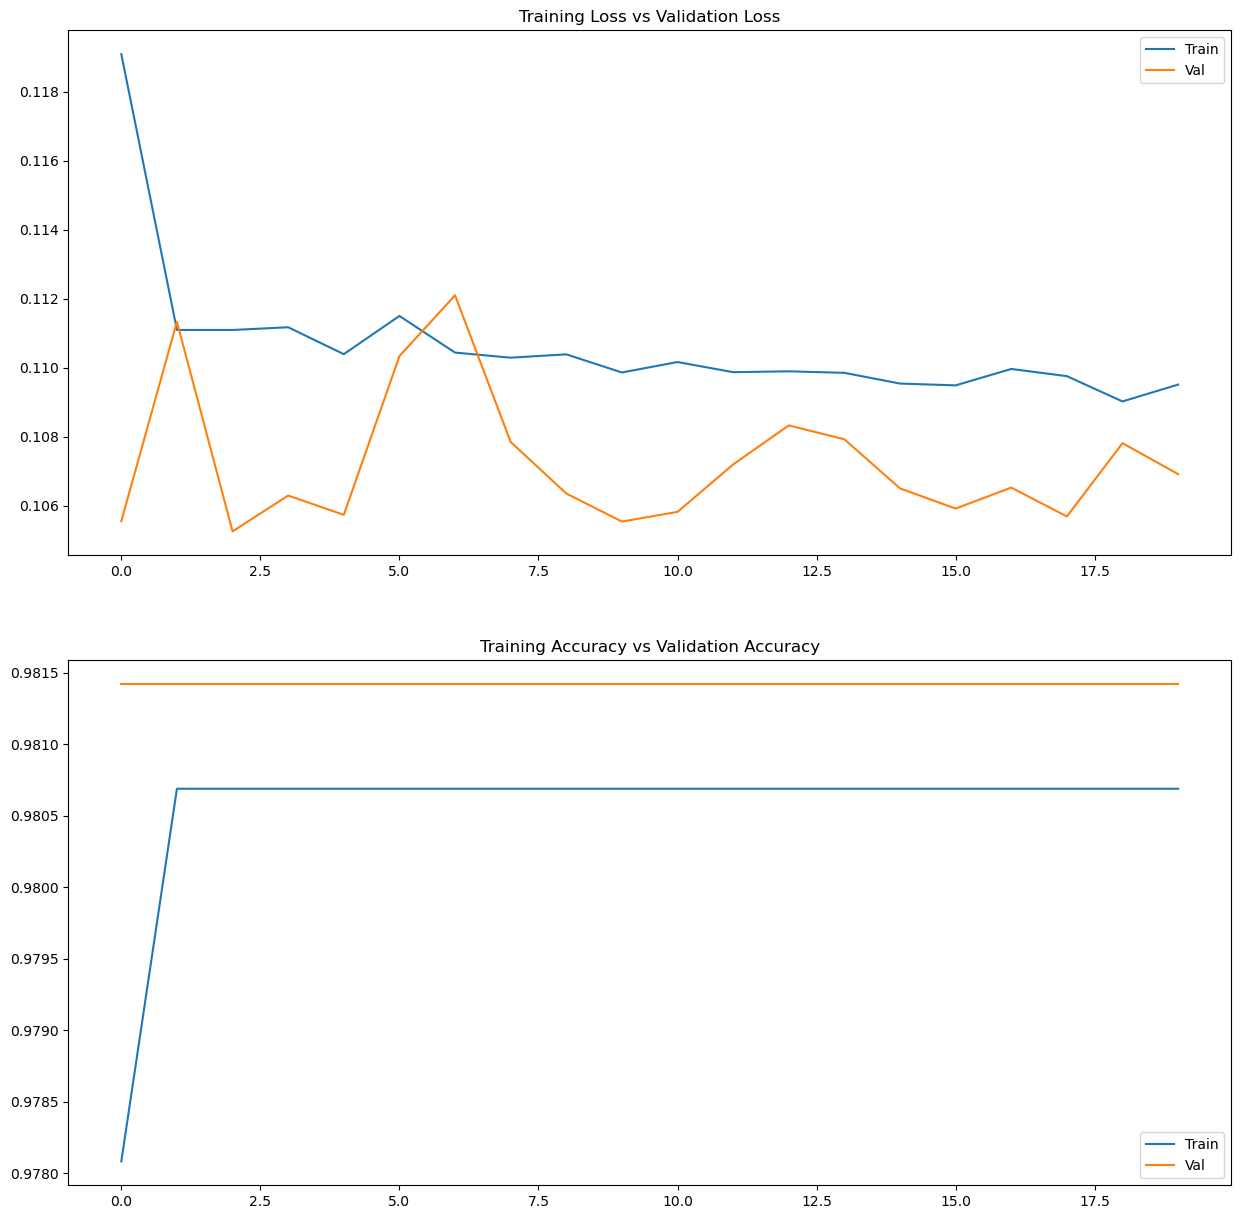

In [78]:
#Instantiate the model with ReLU activation function
model = models.Sequential()
model.add(layers.Conv2D(6, 5, activation='relu', input_shape=x_train.shape[1:]))
model.add(layers.AveragePooling2D(2))
model.add(layers.Activation('sigmoid'))
model.add(layers.Conv2D(16, 5, activation='relu'))
model.add(layers.AveragePooling2D(2))
model.add(layers.Activation('sigmoid'))
model.add(layers.Conv2D(120, 5, activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(84, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
model.summary()
#Sparse categorical corss entropy means one hot encoding of categories is not required
model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy']) 

#Train the model
history = model.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_val, y_val))

#Visually assess the model
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].legend(['Train', 'Val'])
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].legend(['Train', 'Val'])

#Numerically assess the model
model.evaluate(x_test, y_test)

# Densenet-121

Import statements

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, losses
from tqdm import tqdm
import shutil
import ast

Dataframe creation

In [56]:
#Read both csv files into pandas dataframes
regularDataframe = pd.read_csv(r"C:\Users\ethan\Documents\University\2nd Year\ADS2002\CatheterDataset\train.csv")
annotatedDataframe = pd.read_csv(r"C:\Users\ethan\Documents\University\2nd Year\ADS2002\CatheterDataset\train_annotations.csv")

df = regularDataframe.melt(
    id_vars=["StudyInstanceUID", "PatientID"],
    var_name="label",
    value_name="value"
)

# Keep only the rows where the label is present (value == 1)
df = df[df["value"] == 1].drop(columns="value").reset_index(drop=True)

df

,StudyInstanceUID,PatientID,label
0,1.2.826.0.1.3680043.8.498.64512214019606325590...,7e5a85f8a,ETT - Abnormal
1,1.2.826.0.1.3680043.8.498.91744690322677781447...,c4d33e912,ETT - Abnormal
2,1.2.826.0.1.3680043.8.498.13141026863513235286...,6efc4b0b9,ETT - Abnormal
3,1.2.826.0.1.3680043.8.498.97840557219108486344...,871190b8e,ETT - Abnormal
4,1.2.826.0.1.3680043.8.498.13355346266941406291...,804f6d606,ETT - Abnormal
...,...,...,...
50614,1.2.826.0.1.3680043.8.498.15968198647645992711...,2d89916e2,Swan Ganz Catheter Present
50615,1.2.826.0.1.3680043.8.498.44987966894883038046...,5f6e57038,Swan Ganz Catheter Present
50616,1.2.826.0.1.3680043.8.498.11826481935912541615...,fd3ab6f0e,Swan Ganz Catheter Present
50617,1.2.826.0.1.3680043.8.498.34908450415232161801...,78c6b302b,Swan Ganz Catheter Present


Keep only the images that have one catheter 

In [58]:
# Keep only StudyInstanceUIDs that occur exactly once
unique_images = df.groupby("StudyInstanceUID").filter(lambda x: len(x) == 1)
unique_images

,StudyInstanceUID,PatientID,label
9,1.2.826.0.1.3680043.8.498.93345761486297843389...,ebdcd4038,ETT - Abnormal
64,1.2.826.0.1.3680043.8.498.69590675603773156221...,6f110a060,ETT - Abnormal
124,1.2.826.0.1.3680043.8.498.10333305168854328602...,4fae27b09,ETT - Borderline
199,1.2.826.0.1.3680043.8.498.63291566378208548555...,ed36fe59d,ETT - Borderline
242,1.2.826.0.1.3680043.8.498.13301596340518173871...,b03788846,ETT - Borderline
...,...,...,...
49780,1.2.826.0.1.3680043.8.498.85543708701293903513...,1119919df,CVC - Normal
49782,1.2.826.0.1.3680043.8.498.10908982342413107306...,dce9cc938,CVC - Normal
49783,1.2.826.0.1.3680043.8.498.53525361705976355115...,d81b38be3,CVC - Normal
49784,1.2.826.0.1.3680043.8.498.10069840546274743368...,5d0fe98cc,CVC - Normal


Train/test split on dataframe

In [29]:
train_df, test_df = train_test_split(unique_images, test_size=0.2, random_state=3)

Split image folder into train and test folders using exact same split as for the dataframe

In [37]:
#Paths to all images, and the train and test folders
all_images_dir = r"C:\Users\ethan\Documents\University\2nd Year\ADS2002\all_images"
train_dir = r"C:\Users\ethan\Documents\University\2nd Year\ADS2002\CatheterDataset\train"
test_dir  = r"C:\Users\ethan\Documents\University\2nd Year\ADS2002\CatheterDataset\test"

#Make sure that the train/test folders exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

#Function to move images from all_images to dest_dir, guided by the split that has been applied to df
def move_images(df, dest_dir):
    k=0
    for fname in tqdm(df["StudyInstanceUID"], desc=f"Moving to {os.path.basename(dest_dir)}"):
        src = os.path.join(all_images_dir, fname + ".jpg")
        dst = os.path.join(dest_dir, fname + ".jpg")
        if os.path.exists(src):
            shutil.copy(src, dst)
        else:
            k+=1
    return k

#Apply the function to both the train and test images
print(f"Skipped {move_images(train_df, train_dir)} image IDs in train_df")
print(f"Skipped {move_images(test_df, test_dir)} image IDs in test_df")

Moving to train: 100%|██████████| 3739/3739 [00:09<00:00, 387.23it/s]


Skipped 0 image IDs in train_df


Moving to test: 100%|██████████| 935/935 [00:02<00:00, 368.01it/s]

Skipped 0 image IDs in test_df


Format x data by resizing images and putting into an array of length 7254 (train) and 1814 (test). Then, we normalise the pixel values and fix dimensions

In [39]:
x_train=[]

#Loop over all images IDs in the train folder
for fname in tqdm(os.listdir(r"C:\Users\ethan\Documents\University\2nd Year\ADS2002\CatheterDataset\train")):
  #Retrieve the image based on its ID
  img = Image.open(rf"C:\Users\ethan\Documents\University\2nd Year\ADS2002\CatheterDataset\train\{fname}")
  #Resize the image
  img = img.resize((224, 224), Image.Resampling.LANCZOS)
  #Add the image to our list
  x_train.append(img)


100%|██████████| 3739/3739 [02:43<00:00, 22.83it/s]


In [40]:
x_test=[]

#Loop over all images in test folder
for fname in tqdm(os.listdir(r"C:\Users\ethan\Documents\University\2nd Year\ADS2002\CatheterDataset\test")):
  #Retrieve the image based on its ID
  img = Image.open(rf"C:\Users\ethan\Documents\University\2nd Year\ADS2002\CatheterDataset\test\{fname}")
  #Resize the image
  img = img.resize((224, 224), Image.Resampling.LANCZOS)
  #Add the image to our list
  x_test.append(img)

100%|██████████| 935/935 [00:40<00:00, 23.15it/s]


In [111]:
#Create temperary storages for the clean x_train and x_test so we don't have to create x_train and x_test from scratch again
x_train_temp = x_train
x_test_temp = x_test

In [119]:
#Convert PIL images to numpy arrays and normalize the pixel values
x_train = np.array([np.array(img, dtype=np.float32)/255.0 for img in x_train_temp])
x_test  = np.array([np.array(img, dtype=np.float32)/255.0 for img in x_test_temp])

#Add channel dimension so the conv2D layer in the model can work
x_train = np.expand_dims(x_train, axis=-1)  #shape is (7254, 224, 224, 1)
x_test = np.expand_dims(x_test, axis=-1)   #shape is (1814, 32, 224, 1)

#Make last dimension 3 (for models that expect RGB images)
x_train = np.repeat(x_train, 3, axis=-1) 
x_test = np.repeat(x_test, 3, axis=-1) 




Format y data by making an array of CVC, NGT or ETT labels that line up with the images in the x data exactly. Then, we convert y data from 'CVC', 'ETT', 'NGT' to 0,1,2, respectively.

In [131]:
y_train = []

#Loop over all image IDs in train folder
for fname in tqdm(os.listdir(r"C:\Users\ethan\Documents\University\2nd Year\ADS2002\CatheterDataset\train")):
  #Retrieve the catheter type that corresponds to the image ID
  label = train_df[train_df["StudyInstanceUID"] == fname[:-4]].iloc[0,1][0:3]
  #Add the label to our list
  y_train.append(label)



100%|██████████| 7254/7254 [00:10<00:00, 664.51it/s]


In [132]:
y_test = []

#Loop over all images in test folder
for fname in tqdm(os.listdir(r"C:\Users\ethan\Documents\University\2nd Year\ADS2002\CatheterDataset\test")):
  #Retrieve the catheter type that corresponds to the image ID
  label = test_df[test_df["StudyInstanceUID"] == fname[:-4]].iloc[0,1][0:3]
  #Add the label to our list
  y_test.append(label)

100%|██████████| 1814/1814 [00:01<00:00, 1337.98it/s]


In [139]:
#Instantiate the label encoder
le = LabelEncoder()

#Transform the strings to integers
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

A few checks to see if our x and y data is correctly formatted:

In [120]:
x_train.shape

(7254, 224, 224, 3)

In [127]:
y_train[0:5]

array([0, 2, 0, 0, 0], dtype=int64)

In [141]:
len(y_train)

7254

Looking at a snapshot of y_train, there is massive bias towards CVC.

In [75]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2], dtype=int64), array([3653,   45,   41], dtype=int64))

80/20 train/val split

In [143]:
#Set the validation size to 20% of the original train size
val_size = int(len(x_train)/5)

#Create validation splits 
x_val = x_train[-val_size:,:,:,:]
y_val = y_train[-val_size:]

#Cut down train data to exclude the validation splits
x_train = x_train[:-val_size,:,:,:]
y_train = y_train[:-val_size]


Build model

In [149]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models

# 1. Load base DenseNet without top
base_model = DenseNet121(
    include_top=False,          # remove the 1000-class head
    weights="imagenet",         # use pretrained ImageNet weights
    input_shape=(224, 224, 3),  # or (224, 224, 1) after repeating channels
    pooling="avg"               # global average pooling → 1D features
)

# 2. Add custom classifier head
x = layers.Dense(128, activation="relu")(base_model.output)
x = layers.Dropout(0.5)(x)
output = layers.Dense(3, activation="softmax")(x)  # ← 3 classes

# 3. Build model
model = models.Model(inputs=base_model.input, outputs=output)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [153]:
model.summary()

Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,169,091 (27.35 MB)

 Trainable params: 7,085,443 (27.03 MB)

 Non-trainable params: 83,648 (326.75 KB)

Train and evaluate model

In [ ]:
#Sparse categorical corss entropy means one hot encoding of categories is not required
model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy']) 

#Train the model
history = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_val, y_val))

#Visually assess the model
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].legend(['Train', 'Val'])
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].legend(['Train', 'Val'])

#Numerically assess the model
model.evaluate(x_test, y_test)

Epoch 1/10
 80/182 ━━━━━━━━━━━━━━━━━━━━ 18:38 11s/step - accuracy: 0.6994 - loss: 0.7691